# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import libraries for scaling, pca and k-means
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [ ]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

In [ ]:
azdias.head()

From the shape and head of this data we can see that there are 85 columns and 891,221 rows. There appear to be just float and integer data types and some of the data is missing.

Let's look deeper into the data types.

In [ ]:
azdias.dtypes

In [ ]:
azdias.dtypes[29:56]

In [ ]:
print(azdias['OST_WEST_KZ'].value_counts())
print(azdias['CAMEO_DEUG_2015'].value_counts())
print(azdias['CAMEO_DEU_2015'].value_counts())
print(azdias['CAMEO_INTL_2015'].value_counts())

The above cells show that we have mostly float and integer data types. However, there are four columns where we should change the data type and/or clean up.

Let's now look at some other attributes.

In [ ]:
azdias.describe()

In [ ]:
azdias.info()

In [ ]:
feat_info.head()

In [ ]:
feat_info['missing_or_unknown'].value_counts()

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [ ]:
# Create dictionary with columns as the keys and a list of null indicators
nan_values_dict = {}
for i in range(len(feat_info)):
    nan_values_dict[feat_info.iloc[i]['attribute']] = \
    feat_info.iloc[i]['missing_or_unknown'].replace(' ', '').strip('[').strip(']').split(sep=',')

In [ ]:
# Change data type for each value in the lists to int where possible
for key in nan_values_dict:
    for value in range(len(nan_values_dict[key])):
        v = nan_values_dict[key][value]
        if v != '' and v != 'X' and v != 'XX':
            nan_values_dict[key][value] = int(v)

In [ ]:
# Identify missing or unknown data values and convert them to NaNs.
for row in range(len(azdias)):
    for key in nan_values_dict:
        if azdias.loc[row, key] in nan_values_dict[key]:
            azdias.loc[row, key] = np.nan

In [ ]:
azdias.head()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [ ]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum()

In [ ]:
# Investigate patterns in the amount of missing data in each column.
azdias.isnull().sum().hist(bins=100);

In [ ]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_no_outlier = pd.DataFrame()
azdias_outlier = pd.DataFrame()
for i, v in enumerate(azdias.columns):
    if azdias[v].isnull().sum() <= 200000:
        azdias_no_outlier[v] = azdias[v]
    else:
        azdias_outlier[v] = azdias[v]

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [ ]:
# How much data is missing in each row of the dataset?
column_count = azdias_no_outlier.shape[1]
azdias_no_outlier.apply(lambda x: (column_count - x.count()), axis=1).hist(bins=75);


In [ ]:
azdias_low_null = pd.DataFrame(columns=azdias_no_outlier.columns)
azdias_high_null = pd.DataFrame(columns=azdias_no_outlier.columns)

Removing all rows that have null data?

In [ ]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_no_outlier['null_ct_row'] = azdias_no_outlier.isnull().sum(axis=1)
azdias_low_null = azdias_no_outlier.loc[azdias_no_outlier['null_ct_row'] <= 20]
azdias_high_null = azdias_no_outlier.loc[azdias_no_outlier['null_ct_row'] > 20]

In [ ]:
azdias_low_null.drop(['null_ct_row'], axis=1, inplace=True)
azdias_high_null.drop(['null_ct_row'], axis=1, inplace=True)

In [ ]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def value_count_distribution(column_list):
    
    plot_row_index = 0
    plot_rows_count = len(column_list)
    plot_columns_count = 2
    
    fig, axes = plt.subplots(plot_rows_count, plot_columns_count, figsize=(10,plot_rows_count * 2.5))
    fig.suptitle('Column Comparison')
    
    for i in range(plot_rows_count):
        sns.countplot(ax=axes[plot_row_index,0], x=column_list[plot_row_index], data=azdias_low_null)
        axes[plot_row_index,0].set_title('{} for {} Null'.format(column_list[plot_row_index], 'Low'))
    
        sns.countplot(ax=axes[plot_row_index,1], x=column_list[plot_row_index], data=azdias_high_null)
        axes[plot_row_index,1].set_title('{} for {} Null'.format(column_list[plot_row_index], 'High'))
        
        plot_row_index += 1
    
    plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.2, 
                hspace=1);


In [ ]:
azdias_low_null.isnull().sum()

In [ ]:
full_data_columns = ['FINANZ_MINIMALIST', 'SEMIO_MAT', 'KONSUMNAEHE', 'OST_WEST_KZ', 'GEBAEUDETYP_RASTER']

In [ ]:
value_count_distribution(full_data_columns)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [ ]:
# How many features are there of each data type?
feat_info['type'].value_counts()


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Checks for columns with categorical value types in 'feat_info',
# then checks 'a_low_null' for which values need to be changed based on
# number of unique values
# appends list of columns with binary values that need to be updated
# appends list of columns with more than two unique values

binary_value_update = []
one_hot = []
for index in range(len(feat_info)):
    
    if feat_info.iloc[index]['type'] == 'categorical':
        column_name = feat_info.iloc[index]['attribute']
        
        if column_name in azdias_low_null.columns.values.tolist():
            
            if azdias_low_null[column_name].nunique() == 2:                
                binary_value_update.append(column_name)
                
            if azdias_low_null[column_name].nunique() > 2:
                one_hot.append(column_name)


Now it is time to re-encode the columns with categorical variables.

In [ ]:
# columns with binary values that need to be re-encoded
for i in binary_value_update:
    print(azdias_low_null[i].value_counts())

'OST_WEST_KZ' is the only column that needs to be updated because the rest have numbers.

In [ ]:
# Re-encode categorical binary values & check
azdias_low_null['OST_WEST_KZ'] = azdias_low_null['OST_WEST_KZ'].map({'O':0,'W':1})
azdias_low_null['OST_WEST_KZ'].value_counts()

In [ ]:
# Columns that need to have dummies encoded
one_hot

In [ ]:
# One-hot encoding and check
azdias_low_null = pd.get_dummies(azdias_low_null, prefix=one_hot, columns=one_hot)
azdias_low_null.head()

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_low_null['PRAEGENDE_JUGENDJAHRE'].value_counts()


In [ ]:
# Create 'Decade' and 'Movement' columns
conditions = [
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 1),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 2),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 3),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 4),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 5),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 6),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 7),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 8),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 9),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 10),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 11),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 12),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 13),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 14),
    (azdias_low_null['PRAEGENDE_JUGENDJAHRE'] == 15),
]

# assign 'Decade' values
# null == 0
# 40s == 1
# 50s == 2
# 60s == 3
# 70s == 4
# 80s == 5
# 90s == 6
decade_value = [1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5, 6, 6]
azdias_low_null['Decade'] = np.select(conditions, decade_value)

# assign 'Movement' values
# Mainstream == 1
# Avantgarde == 0
movement_value = [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
azdias_low_null['Movement'] = np.select(conditions, movement_value)

In [ ]:
azdias_low_null['Decade'].value_counts()

In [ ]:
azdias_low_null['Movement'].value_counts()

In [ ]:
# drop 'PRAEGENDE_JUGENDJAHRE' column
azdias_low_null.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

In [ ]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_low_null['CAMEO_INTL_2015'].value_counts()


In [ ]:
# Create 'wealth_level' column
# 1: Wealthy
# 2: Prosperous
# 3: Comfortable
# 4: Less Affluent
# 5: Poorer
azdias_low_null['wealth_level'] = azdias_low_null['CAMEO_INTL_2015'].str.get(0)

In [ ]:
# Create 'life_stage' column
# 1: Pre-Family Couples & Singles
# 2: Young Couples With Children
# 3: Families With School Age Children
# 4: Older Families &  Mature Couples
# 5: Elders In Retirement
azdias_low_null['life_stage'] = azdias_low_null['CAMEO_INTL_2015'].str.get(1)

In [ ]:
azdias_low_null['wealth_level'].value_counts()

In [ ]:
azdias_low_null['life_stage'].value_counts()

In [ ]:
azdias_low_null.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

##### Cleanup  other columns with 'mixed' data type

Here is a list of the "mixed" columns that remain after our initial cleanup.

In [ ]:
# find "mixed" columns in 'feat_info'
mixed_columns = []
for index in range(len(feat_info)):
    
    if feat_info.iloc[index]['type'] == 'mixed':
        column_name = feat_info.iloc[index]['attribute']
        mixed_columns.append(column_name)

# see which "mixed" columns are left in 'a_low_null'
for i in mixed_columns:
    if i in azdias_low_null.columns:
        print(i)

According to the "Data_Dictionary.md", "PLZ8_BAUMAX" (type of homes in region), has an ordinal value that is used to show the increasing mode size of homes in the neighborhood. For "WOHNLAGE" (neighborhood quality or rural flag), an ordinal value is used to show the increasing quality of a neighborhood. For these reasons, "PLZ8_BAUMAX" and "WOHNLAGE" can stay as is.

"LP_LEBENSPHASE_GROB" is a grouping of information in "LP_LEBENSPHASE_FEIN". The information in "LP_LEBENSPHASE_GROB" is broken down further in "LP_FAMILIE_GROB" (family type) and "LP_STATUS_GROB" (social status). The age of an individual is not found in any other column and may be a candidate for extraction. However, the individuals age group can only be found in 29 of the 40 unique values in "LP_STATUS_GROB" and half of the 12 unique values in  "LP_LEBENSPHASE_GROB". These two features are either redundant, or there will be too many null values (in the case of age) to be of any use. For these reasons, "LP_LEBENSPHASE_FEIN" and "LP_LEBENSPHASE_GROB" will be dropped.

In [ ]:
azdias_low_null.drop(['LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)
azdias_low_null.drop(['LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # Step 1: convert missing value codes into NaNs, ...
    
    # Create dictionary with columns as the keys and a list of null indicators
    nan_values_dict = {}
    for i in range(len(feat_info)):
        nan_values_dict[feat_info.iloc[i]['attribute']] = \
        feat_info.iloc[i]['missing_or_unknown'].replace(' ', '').strip('[').strip(']').split(sep=',')
    # Change data type for each value in the lists to int where possible
    for key in nan_values_dict:
        for value in range(len(nan_values_dict[key])):
            v = nan_values_dict[key][value]
            if v != '' and v != 'X' and v != 'XX':
                nan_values_dict[key][value] = int(v)
    # Identify missing or unknown data values and convert them to NaNs.
    for row in range(len(df)):
        for key in nan_values_dict:
            if df.loc[row, key] in nan_values_dict[key]:
                df.loc[row, key] = np.nan            
    
    # Step 2: remove selected columns and rows, ...
    
    # Remove the outlier columns from the dataset.
    df_no_outlier = pd.DataFrame()
    df_outlier = pd.DataFrame()
    for i, v in enumerate(df.columns):
        if df[v].isnull().sum() <= 200000:
            df_no_outlier[v] = df[v]
        else:
            df_outlier[v] = df[v]
    
    # Divide the data into two subsets based on the number of missing
    # values in each row.
    df_no_outlier['null_ct_row'] = df_no_outlier.isnull().sum(axis=1)
    df_low_null = df_no_outlier.loc[df_no_outlier['null_ct_row'] <= 20]
    df_high_null = df_no_outlier.loc[df_no_outlier['null_ct_row'] > 20]
    
    df_low_null.drop(['null_ct_row'], axis=1, inplace=True)
    df_high_null.drop(['null_ct_row'], axis=1, inplace=True)

    # Step 3: select, re-encode, and engineer column values.
    
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?

    # Checks for columns with categorical value types in 'feat_info',
    # then checks 'a_low_null' for which values need to be changed based on
    # number of unique values
    # appends list of columns with binary values that need to be updated
    # appends list of columns with more than two unique values

    binary_value_update = []
    one_hot = []
    for index in range(len(feat_info)):

        if feat_info.iloc[index]['type'] == 'categorical':
            column_name = feat_info.iloc[index]['attribute']

            if column_name in df_low_null.columns.values.tolist():

                if df_low_null[column_name].nunique() == 2:
                    binary_value_update.append(column_name)

                if df_low_null[column_name].nunique() > 2:
                    one_hot.append(column_name)
    
    # Re-encode categorical binary values & check
    df_low_null['OST_WEST_KZ'] = df_low_null['OST_WEST_KZ'].map({'O':0,'W':1})
    
    # One-hot encoding
    df_low_null = pd.get_dummies(df_low_null, prefix=one_hot, columns=one_hot)
    
    # Create 'Decade' and 'Movement' columns from 'PRAEGENDE_JUGENDJAHRE' column
    conditions = [
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 1),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 2),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 3),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 4),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 5),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 6),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 7),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 8),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 9),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 10),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 11),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 12),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 13),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 14),
        (df_low_null['PRAEGENDE_JUGENDJAHRE'] == 15),
    ]
    
    # assign 'Decade' values
    # null == 0
    # 40s == 1
    # 50s == 2
    # 60s == 3
    # 70s == 4
    # 80s == 5
    # 90s == 6
    decade_value = [1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5, 6, 6]
    df_low_null['Decade'] = np.select(conditions, decade_value)

    # assign 'Movement' values
    # Mainstream == 1
    # Avantgarde == 0
    movement_value = [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
    df_low_null['Movement'] = np.select(conditions, movement_value)
    
    # Create 'wealth_level' column from 'CAMEO_INTL_2015' column
    # 1: Wealthy
    # 2: Prosperous
    # 3: Comfortable
    # 4: Less Affluent
    # 5: Poorer
    df_low_null['wealth_level'] = df_low_null['CAMEO_INTL_2015'].str.get(0)
    
    # Create 'life_stage' column from 'CAMEO_INTL_2015' column
    # 1: Pre-Family Couples & Singles
    # 2: Young Couples With Children
    # 3: Families With School Age Children
    # 4: Older Families &  Mature Couples
    # 5: Elders In Retirement
    df_low_null['life_stage'] = df_low_null['CAMEO_INTL_2015'].str.get(1)
    
    # drop columns that are redundant
    df_low_null.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    df_low_null.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    df_low_null.drop(['LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)
    df_low_null.drop(['LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    # replace null values with '-1' and change data type all of 'a_clean' to int64
    df_clean = df_low_null.fillna('-1').astype('int64')
    
    # Step 4: Return the cleaned dataframe.
    return df_clean

In [4]:
azdias_clean = clean_data(azdias)

C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\4100548783.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low_null.drop(['null_ct_row'], axis=1, inplace=True)
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\4100548783.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_null.drop(['null_ct_row'], axis=1, inplace=True)
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\4100548783.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
azdias_clean.shape

In [ ]:
azdias.shape

In [ ]:
percent_rows_remaining = round(100 * (azdias_clean.shape[0] / azdias.shape[0]), 2)
print('After cleaning, {}% of the original rows remain.'.format(percent_rows_remaining))

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
total_null = azdias_clean.isnull().sum().sum()
total_values = azdias_clean.shape[0] * azdias_clean.shape[1]
percent_null = round(100 * (total_null / total_values), 2)
print('After removing outliers from our original data frame, {}% of the remaining values are null.'.format(percent_null))


Since only 0.46% of the remaining data is null, we do not want to remove a whole row if it contains a null value. We would lose too much data. Instead, we will replace the null values with a number to allow us to scale the data. We do not want to use 0, because some columns already have a 0 (like 'OST_WEST_KZ') that means something else. We do not want to replace the null with mean, median or mode, because there are many ordinal column where these values won't mean anything. So, we will replace the null value with a value of -1.

The following two lines of code will be added to the 'clean_data' function.

In [ ]:
# replace null values with '-1'
azdias_clean = azdias_clean.fillna('-1')

In [ ]:
# change data type all of 'a_clean' to int64
azdias_clean = azdias_clean.astype('int64')

Now we can check that the clean data is what we were hoping.

In [6]:
azdias_clean.isnull().sum().sum()

0

In [7]:
# check data type and value counts
for i in azdias_clean:
    print(azdias_clean[i].value_counts())

 3    310089
 4    223136
 2    137053
 1    124364
-1      2784
Name: ALTERSKATEGORIE_GROB, dtype: int64
2    415781
1    381645
Name: ANREDE_KZ, dtype: int64
3    180484
5    161149
4    159512
2    157735
1    138546
Name: FINANZ_MINIMALIST, dtype: int64
1    244105
2    148798
5    143791
3    138023
4    122709
Name: FINANZ_SPARER, dtype: int64
5    235878
4    192644
3    152980
2    112778
1    103146
Name: FINANZ_VORSORGER, dtype: int64
1    208437
2    158131
5    154873
4    138105
3    137880
Name: FINANZ_ANLEGER, dtype: int64
1    220334
2    183794
3    161384
5    119237
4    112677
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
5    183906
2    166201
3    157556
4    156565
1    133198
Name: FINANZ_HAUSBAUER, dtype: int64
0    622259
1    175167
Name: GREEN_AVANTGARDE, dtype: int64
 3    307864
 2    296859
 1    156286
-1     36417
Name: HEALTH_TYP, dtype: int64
 5    281918
 3    174161
 4    123338
 1    122753
 2     90622
-1      4634
Name: RETOURTYP_BK_S, dtype: int64


Name: LP_FAMILIE_FEIN_4.0, dtype: int64
0    786260
1     11166
Name: LP_FAMILIE_FEIN_5.0, dtype: int64
0    788906
1      8520
Name: LP_FAMILIE_FEIN_6.0, dtype: int64
0    777855
1     19571
Name: LP_FAMILIE_FEIN_7.0, dtype: int64
0    775648
1     21778
Name: LP_FAMILIE_FEIN_8.0, dtype: int64
0    786974
1     10452
Name: LP_FAMILIE_FEIN_9.0, dtype: int64
0    668502
1    128924
Name: LP_FAMILIE_FEIN_10.0, dtype: int64
0    748692
1     48734
Name: LP_FAMILIE_FEIN_11.0, dtype: int64
1    402379
0    395047
Name: LP_FAMILIE_GROB_1.0, dtype: int64
0    698904
1     98522
Name: LP_FAMILIE_GROB_2.0, dtype: int64
0    770001
1     27425
Name: LP_FAMILIE_GROB_3.0, dtype: int64
0    747557
1     49869
Name: LP_FAMILIE_GROB_4.0, dtype: int64
0    609316
1    188110
Name: LP_FAMILIE_GROB_5.0, dtype: int64
0    590608
1    206818
Name: LP_STATUS_FEIN_1.0, dtype: int64
0    686392
1    111034
Name: LP_STATUS_FEIN_2.0, dtype: int64
0    728520
1     68906
Name: LP_STATUS_FEIN_3.0, dtype: int64
0

There are no null values and the -1s seem to have been assigned correctly.

Now we can sort and scale the data using StandardScaler. This distributes the data according to the mean and standard deviation.

In [8]:
# sort data so transforming works correctly
columns_azdias = list(azdias_clean.columns)
columns_azdias.sort()
azdias_clean_sorted = azdias_clean[columns_azdias]

In [9]:
# Apply feature scaling to the general population demographics data.
st_scaler_a = StandardScaler()
azdias_scaled = st_scaler_a.fit_transform(azdias_clean_sorted)


In [10]:
# create dataframe of scaled data
azdias_scaled_df = pd.DataFrame(azdias_scaled, columns=azdias_clean.columns)

In [11]:
azdias_scaled_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Decade,Movement,wealth_level,life_stage
0,-1.711725,0.958071,0.173733,-0.108111,0.233996,-0.06057,-0.139115,0.846119,-0.218033,-0.341246,...,-0.027548,-0.358133,-0.427707,-0.207652,-0.739580,-0.592927,2.975446,-0.312245,-1.215695,1.175989
1,0.209325,0.958071,0.109784,-0.108111,-0.630760,-0.06057,-0.139115,-0.982508,-0.218033,-0.341246,...,-1.053985,-0.358133,-0.427707,-0.207652,-0.739580,-0.592927,2.975446,-0.312245,0.762325,-0.817643
2,1.169849,0.958071,-0.465756,-0.108111,-1.495517,-0.06057,-1.099509,-0.068194,-0.218033,2.930434,...,1.512108,-2.192897,-0.427707,-0.207652,1.352118,-0.592927,-0.336084,-0.312245,-0.556355,-1.482187
3,0.209325,-1.043765,-0.337858,-0.108111,1.963509,-0.06057,0.821278,-0.982508,-0.218033,-0.341246,...,-0.540766,-0.816824,-0.427707,-0.207652,-0.739580,1.686548,-0.336084,-0.312245,0.102985,0.511445
4,-1.711725,0.958071,-0.209960,-0.108111,-0.630760,-0.06057,-1.099509,0.846119,-0.218033,-0.341246,...,1.512108,1.017940,-0.427707,-0.207652,-0.739580,1.686548,-0.336084,-0.312245,0.762325,1.175989


### Discussion 2.1: Apply Feature Scaling

We used StandardScaler to distribue the data according to mean and standard deviation. This allows us to work with normalized data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [12]:
# Apply PCA to the data.
pca = PCA()
pca_azdias_fit = pca.fit(azdias_scaled_df)


In [13]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca, fig, font):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=fig)
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    plt.xticks(fontsize=(font - 10))
    plt.yticks(fontsize=(font - 10))
 
    ax.set_xlabel("Principal Component", fontsize=font)
    ax.set_ylabel("Variance Explained (%)", fontsize=font)
    plt.title('Explained Variance Per Principal Component', fontsize=font)


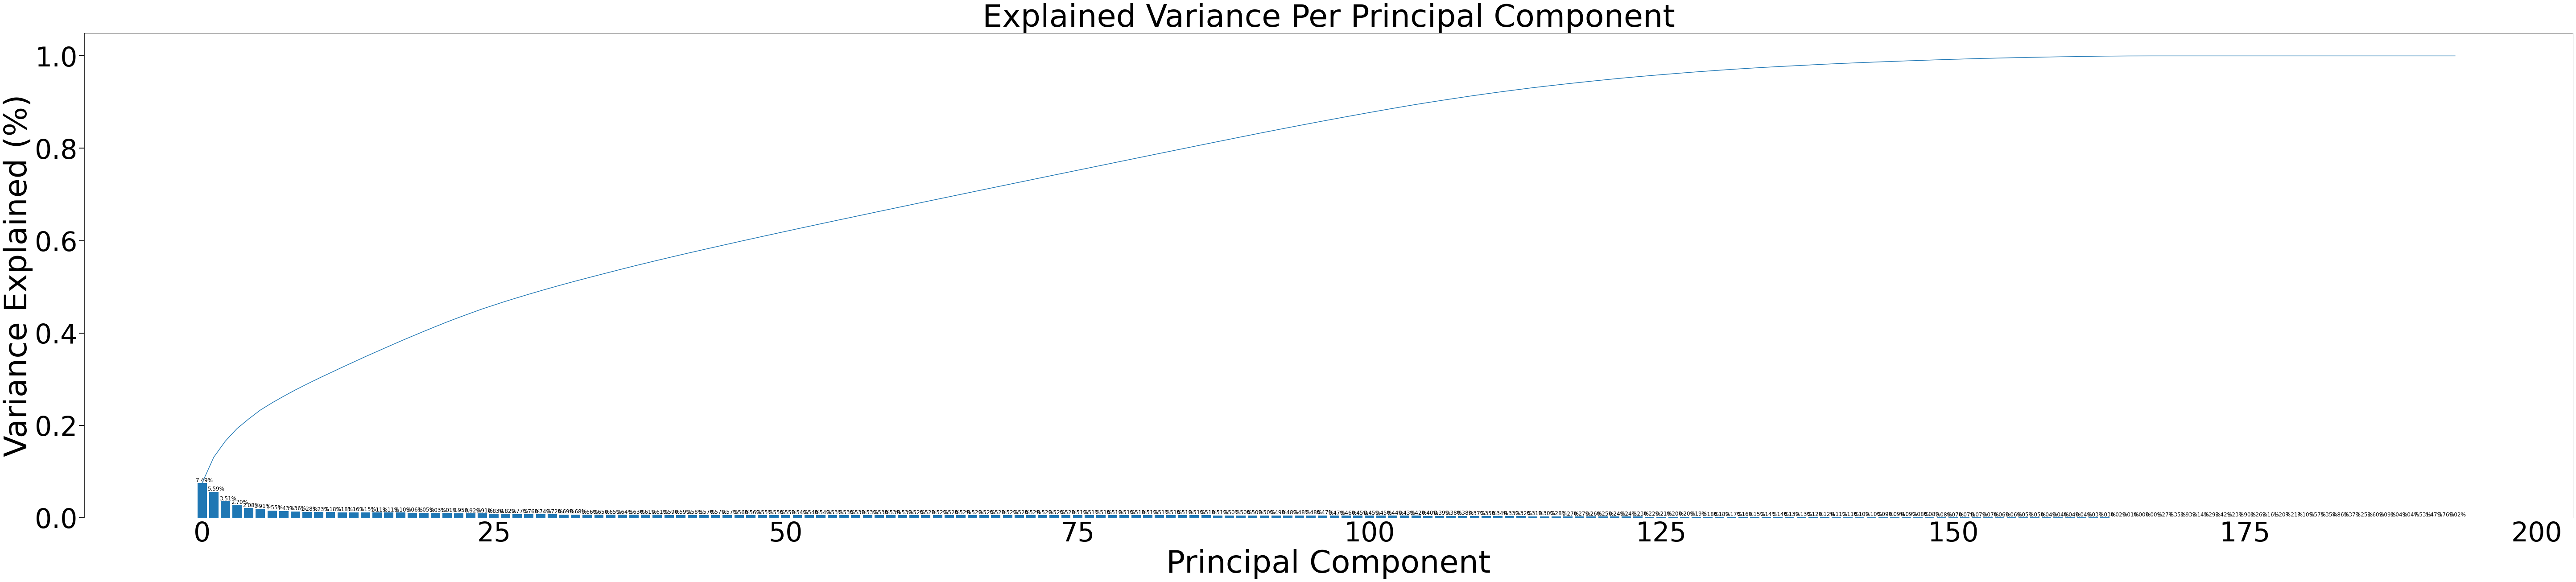

In [14]:
figure_size = (100, 20)
font_size = (70)
scree_plot(pca_azdias_fit, figure_size, font_size)

From the above screeplot, we can see that 95% of the variance is explained with approx. 125 components. Let's investigate which number of components exactly gets us just over 95% by tweaking the following code.

In [20]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_122 = PCA(122)
pca_122_azdias_fit = pca_122.fit(azdias_scaled_df)
pca_122_azdias_fit.explained_variance_ratio_.sum()

0.9501398893555033

It looks like 122 components just puts us over the 95% variance explained mark.

Now let's create a reduced dataframe with only 122 components and see how the scree plot looks.

In [17]:
pca_122_azdias_transform = pca_122_azdias_fit.transform(azdias_scaled_df)
azdias_reduced_df = pd.DataFrame(pca_122_azdias_transform)

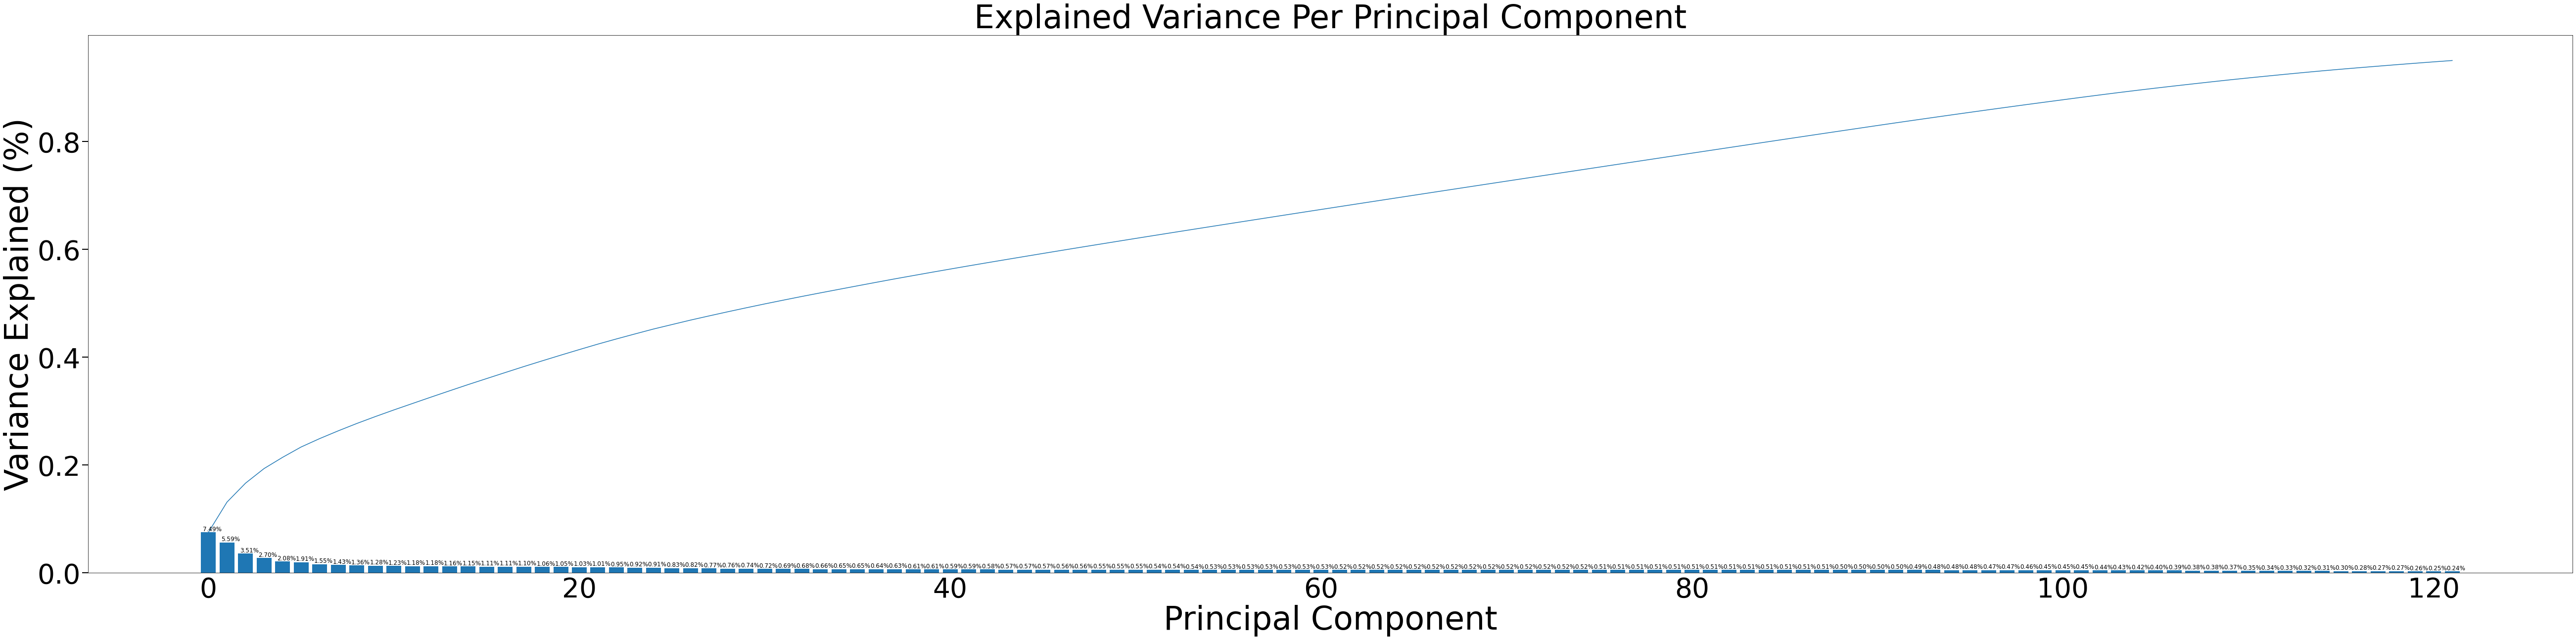

In [18]:
figure_size = (90, 20)
font_size = (65)
scree_plot(pca_122_azdias_fit, figure_size, font_size)

In [24]:
pca_30 = PCA(32)
pca_30_azdias_fit = pca_30.fit(azdias_scaled_df)
pca_30_azdias_fit.explained_variance_ratio_.sum()

0.502231899173126

In [28]:
pca_7 = PCA(7)
pca_7_azdias_fit = pca_7.fit(azdias_scaled_df)
pca_7_azdias_fit.explained_variance_ratio_.sum()

0.24874780420713516

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

We used a 122 principle components which explains 95% of the variance. Since time is not an issue, it would be helpful to keep this amount of data and see what we get.

If time were and issue, 32 components explain 50% of the data and 7 components explain approximately 25% of the data. We could do the following analysis for each of these component numbers and see how they compare to when we are able to explain 95% of the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

We will first create several functions to help us investigate the features for our principle components.

In [33]:
def get_component(pca, comp):
    '''Takes pca and a component and return a dataframe of the 
    features with top weights after plotting those features and their
    corresponding weights
    '''
    try:
        weight_df = pd.DataFrame({'weight': pca.components_[comp]}, index = azdias_scaled_df.columns)
        top_weight = pd.concat([weight_df.sort_values(by='weight', ascending=False).head(), weight_df.sort_values(by='weight', ascending=False).tail()])
        top_weight.reset_index(inplace=True)
        top_weight.rename(columns={'index':'feature'}, inplace=True)
    except:
        print('There are not that many components in pca.')
    
    plot_top_features(top_weight, comp)
    
    return top_weight

The Geeks for Geeks website provides a helpful tutorial on making a horizontal bar chart at [geeksforgeeks.com](https://www.geeksforgeeks.org/bar-plot-in-matplotlib/).

In [30]:
def plot_top_features(df, comp):
    '''Takes a dataframe and a component and plots the features with
    top weights along with their corresponding weights
    '''
    
    feature = df['feature']
    weight = df['weight']

    fig, ax = plt.subplots(figsize =(16, 9))

    ax.barh(feature, weight)
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    ax.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)

    ax.invert_yaxis()


    ax.set_title('Top Feature Weights for Component {}'.format(comp),
                 fontsize = 20,
                 loc ='left', )
    plt.ylabel('Feature', fontsize=17)
    plt.xlabel('Weights', fontsize=17)

    # Show Plot
    plt.show()

In [31]:
def get_duplicates(data_frame_list):
    '''Takes a list of dataframes. Returns and prints a series of duplicate features.
    '''
    top_features_df = pd.DataFrame(columns=data_frame_list[0].columns)
    for i in range(len(data_frame_list)):
        new_data_frame = data_frame_list[i]
        top_features_df = pd.concat([top_features_df, new_data_frame])
        
    top_features_series = top_features_df['feature']
    duplicate_features = top_features_series[top_features_series.duplicated()]
    print('Duplicate Features')
    print(duplicate_features)
    
    return duplicate_features

In [32]:
def compare_top_features(data_frame_list):
    '''Takes a list of dataframes. Returns and prints a series of duplicate features.
    Also plots the features with the top weights for for each dataframe.
    '''
    if len(data_frame_list) > 1:
        get_duplicates(data_frame_list)
    
    for i in range(len(data_frame_list)):
        plot_top_features(data_frame_list[i], i)

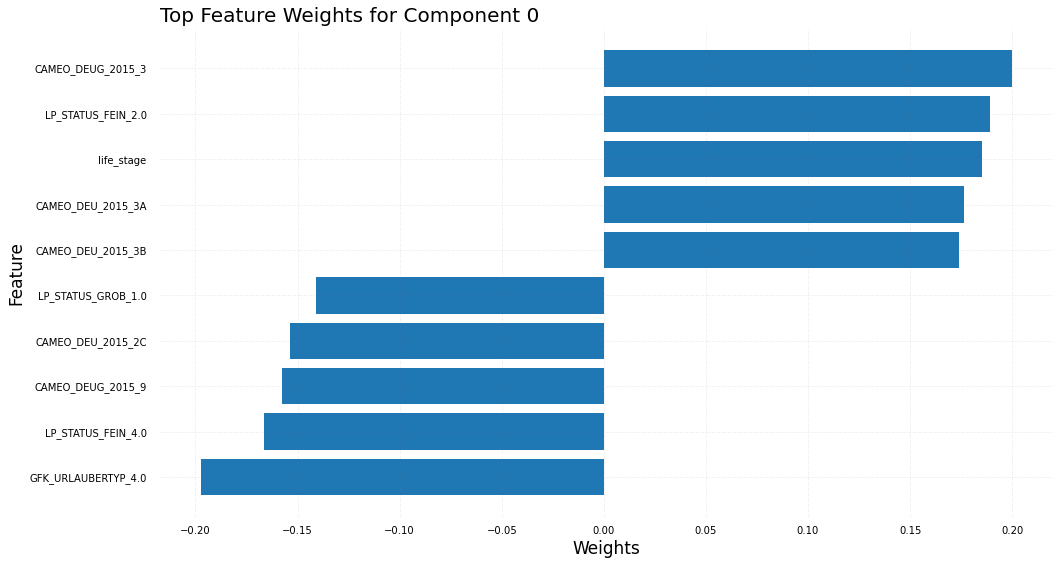

In [34]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_df0 = get_component(pca_122_azdias_fit,0)

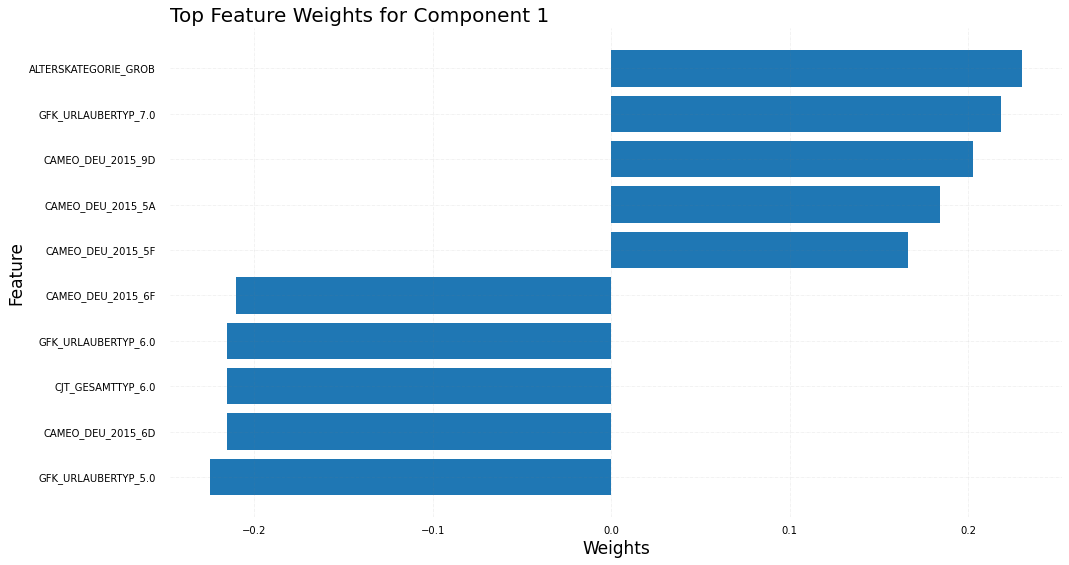

In [35]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_df1 = get_component(pca_122_azdias_fit,1)


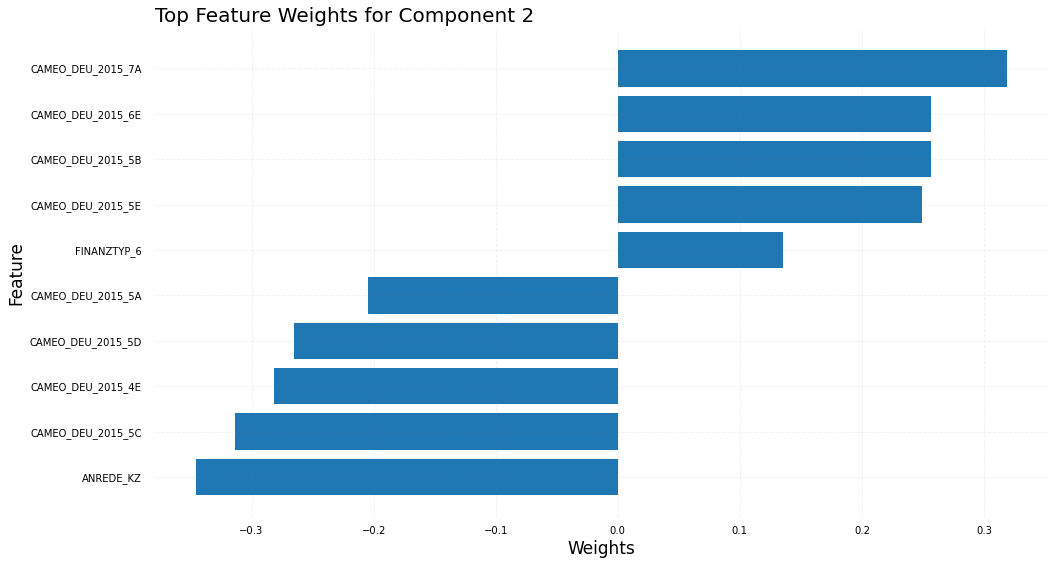

In [36]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_df2 = get_component(pca_122_azdias_fit,2)


Let's see if there are any duplicate top features for the top three components.

In [37]:
dataframe_list = [weight_df0, weight_df1, weight_df2]
get_duplicates(dataframe_list)

Duplicate Features
5    CAMEO_DEU_2015_5A
Name: feature, dtype: object


5    CAMEO_DEU_2015_5A
Name: feature, dtype: object

### Discussion 2.3: Interpret Principal Components
After creating a list of top features for each of the top three components, we can see that only 'SEMIO_ERL' is in more than on top features list. Upon further investigation, we see that 'SEMIO_ERL' has a positive correlation in component 1 and a negative correlation in component 2. This means that we are not able to interpret positive or negative values in any meaningful way for the top three components.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [38]:
# taken from course material
def get_kmeans_score(data, cluster_ct):
    ''' Takes data and a cluster count.
    Returns the kmeans score regarding SSE for points to centers.
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=cluster_ct)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [39]:
# SSE score over a number of different cluster counts
cluster_counts = [10, 15, 20]
for i in cluster_counts:
    print('{} clusters scores {}'.format(i, get_kmeans_score(azdias_reduced_df, i)))

10 clusters scores 121740829.03238943
15 clusters scores 117311784.23798063
20 clusters scores 114365512.55103232


In [40]:
# Investigate the change in within-cluster distance across number of clusters.
# taken from course material with adjustments in fontsize
def plot_kmeans_score(data, cluster_ct):
    '''Takes data and cluster count.
    Returns a plot of the SSE score for each cluster count up to the
    provided cluster count.
    '''
    scores = []
    centers = list(range(1, cluster_ct))

    for center in centers:
        scores.append(get_kmeans_score(data, center))

    plt.figure(figsize=(70,30));
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    plt.xlabel('Number of Clusters', fontsize=50);
    plt.ylabel('SSE Score', fontsize=50);
    plt.title('SSE Score by Cluster Count', fontsize=70);


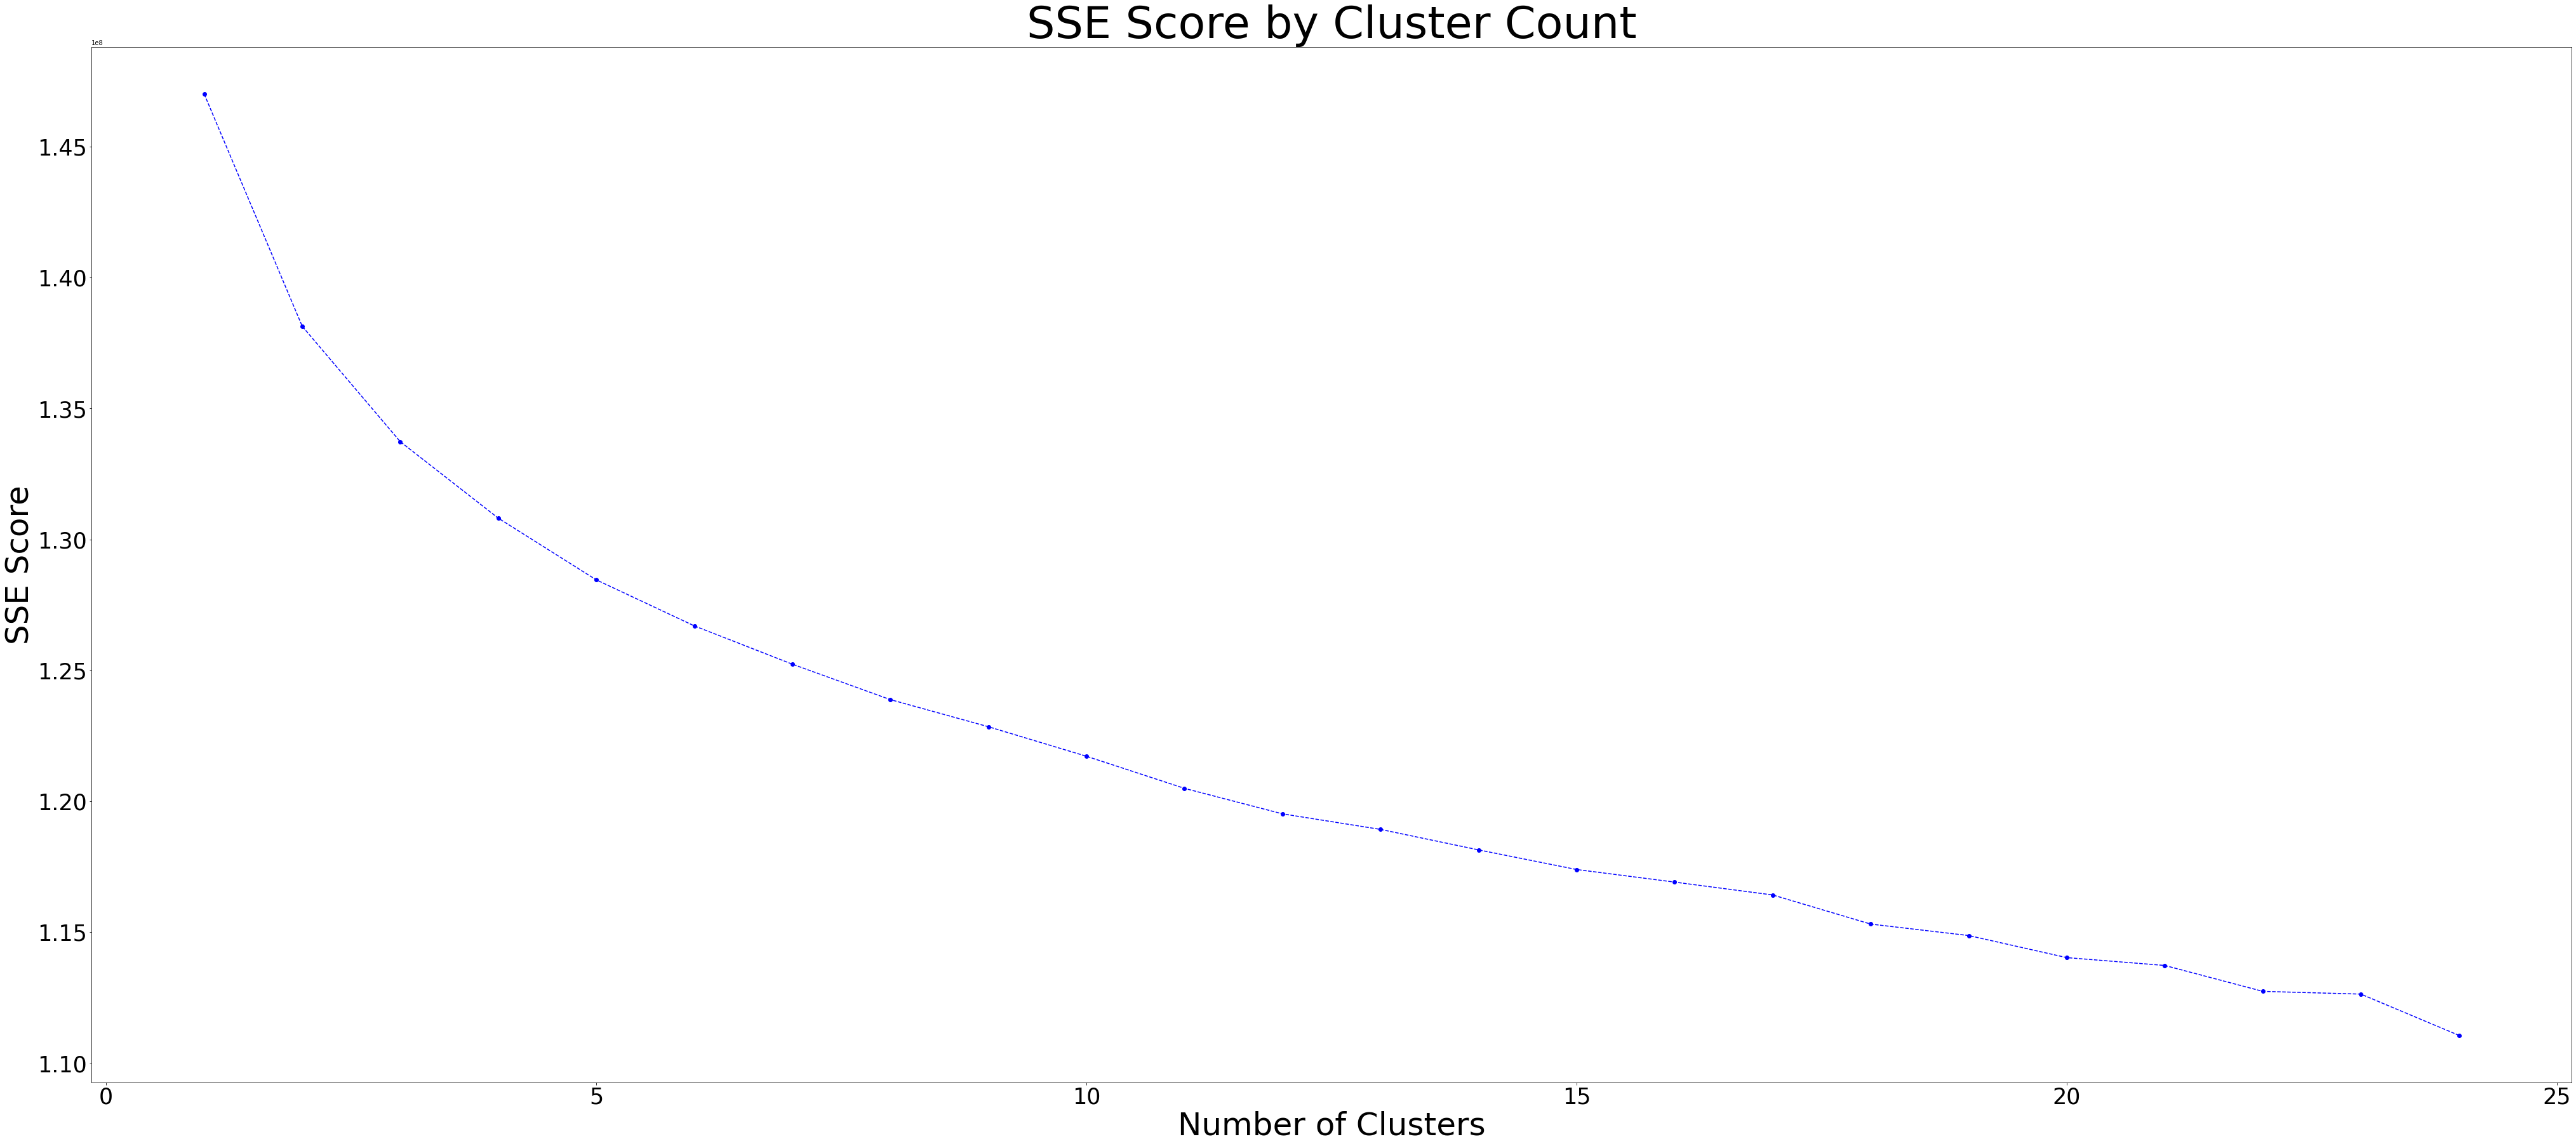

In [41]:
plot_kmeans_score(azdias_reduced_df, 25)

It appears that the elbow is at approximately 10 clusters.

In [42]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_10 = KMeans(n_clusters=10)
azdias_predictions = kmeans_10.fit_predict(azdias_reduced_df)


In [43]:
# create dataframe of predictions
azdias_preds_df = pd.DataFrame(azdias_predictions, columns=['predictions'])

### Discussion 3.1: Apply Clustering to General Population

The change in KMeans Score by Number of Clusters starts to flatten out at 10 clusters - so, we will segment the population into 10 clusters for our modelling going forward. Each successive cluster does not change the SSE score as much as each of the first ten clusters did.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [44]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [45]:
# check the size of our customer data before cleaning
customers.shape

(191652, 85)

In [46]:
# clean customer data
customers_clean = clean_data(customers)
customers_clean.head()

C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\4100548783.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low_null.drop(['null_ct_row'], axis=1, inplace=True)
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\4100548783.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_null.drop(['null_ct_row'], axis=1, inplace=True)
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\4100548783.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Decade,Movement,wealth_level,life_stage
0,4,1,5,1,5,1,2,2,-1,1,...,0,0,0,0,0,0,2,0,1,3
2,4,2,5,1,5,1,4,4,-1,1,...,0,0,0,0,0,0,2,0,3,4
3,4,1,5,1,5,2,1,2,-1,0,...,0,0,0,0,0,0,1,1,2,4
4,3,1,3,1,4,4,5,2,1960,0,...,0,0,0,0,0,0,4,1,4,1
5,3,1,5,1,5,1,2,3,-1,1,...,0,0,0,0,0,0,2,0,3,4


Let's now investigate how the cleaning has affected the size of our data and if there are any more steps to take to get our data ready for scaling.

In [47]:
# check the size of our customer data after cleaning
customers_clean.shape

(141178, 209)

In [48]:
percent_rows_remaining = round(100 * (customers_clean.shape[0] / customers.shape[0]), 2)
print('After cleaning, {}% of the original rows remain.'.format(percent_rows_remaining))

After cleaning, 73.66% of the original rows remain.


In [49]:
for i in customers_clean:
    print(customers_clean[i].value_counts())

 4    83729
 3    47192
 2     5112
 1     4916
-1      229
Name: ALTERSKATEGORIE_GROB, dtype: int64
1    94509
2    46669
Name: ANREDE_KZ, dtype: int64
5    81834
4    28167
3    19669
2     9797
1     1711
Name: FINANZ_MINIMALIST, dtype: int64
1    102669
2     23962
3      8800
4      3885
5      1862
Name: FINANZ_SPARER, dtype: int64
5    101622
4     26109
3      7617
2      3202
1      2628
Name: FINANZ_VORSORGER, dtype: int64
1    92939
2    25454
3    12338
4     7042
5     3405
Name: FINANZ_ANLEGER, dtype: int64
1    61278
2    51035
3    20238
4     4419
5     4208
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2    51931
3    24703
1    24171
5    21964
4    18409
Name: FINANZ_HAUSBAUER, dtype: int64
-1       45152
 1941     3462
 1940     3009
 1939     2999
 1943     2813
         ...  
 2006        2
 2010        2
 1902        1
 1909        1
 1908        1
Name: GEBURTSJAHR, Length: 113, dtype: int64
0    70883
1    70295
Name: GREEN_AVANTGARDE, dtype: int64
 2    55768
 1 

Name: LP_FAMILIE_FEIN_2.0, dtype: int64
0    141037
1       141
Name: LP_FAMILIE_FEIN_3.0, dtype: int64
0    140658
1       520
Name: LP_FAMILIE_FEIN_4.0, dtype: int64
0    140349
1       829
Name: LP_FAMILIE_FEIN_5.0, dtype: int64
0    140419
1       759
Name: LP_FAMILIE_FEIN_6.0, dtype: int64
0    138412
1      2766
Name: LP_FAMILIE_FEIN_7.0, dtype: int64
0    136782
1      4396
Name: LP_FAMILIE_FEIN_8.0, dtype: int64
0    138922
1      2256
Name: LP_FAMILIE_FEIN_9.0, dtype: int64
0    107427
1     33751
Name: LP_FAMILIE_FEIN_10.0, dtype: int64
0    120337
1     20841
Name: LP_FAMILIE_FEIN_11.0, dtype: int64
0    102721
1     38457
Name: LP_FAMILIE_GROB_1.0, dtype: int64
0    113920
1     27258
Name: LP_FAMILIE_GROB_2.0, dtype: int64
0    139688
1      1490
Name: LP_FAMILIE_GROB_3.0, dtype: int64
0    133257
1      7921
Name: LP_FAMILIE_GROB_4.0, dtype: int64
0    84330
1    56848
Name: LP_FAMILIE_GROB_5.0, dtype: int64
0    123214
1     17964
Name: LP_STATUS_FEIN_1.0, dtype: int64
0

In [50]:
# create a dataframe from the cleaned customer data with the same columns as the cleaned general population data
customers_clean_new = pd.DataFrame()
for i in customers_clean.columns:
    if i in azdias_clean.columns:
        customers_clean_new[i] = customers_clean[i]

C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean_new[i] = customers_clean[i]
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean_new[i] = customers_clean[i]
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean_new[i] = customers_clean[i]
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean_new[i] = customers_clean[i]
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean_new[i] = customers_clean[i]
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean_new[i] = customers_clean[i]
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean_new[i] = customers_clean[i]
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean_new[i] = customers_clean[i]
C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\3260817672.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [51]:
# look for any missing columns in the cleaned customer data
test = pd.DataFrame()
for i in azdias_clean.columns:
    if i not in customers_clean_new.columns:
        print(i)

GEBAEUDETYP_5.0


In [52]:
# add the missing column to the cleaned customer data filled with -1s which represent null data
customers_clean_new['GEBAEUDETYP_5.0'] = -1

C:\Users\jonny\AppData\Local\Temp\ipykernel_92484\2648695162.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean_new['GEBAEUDETYP_5.0'] = -1


In [53]:
customers_clean_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Decade,Movement,wealth_level,life_stage,GEBAEUDETYP_5.0
0,4,1,5,1,5,1,2,2,1,1,...,0,0,0,0,0,2,0,1,3,-1
2,4,2,5,1,5,1,4,4,1,2,...,0,0,0,0,0,2,0,3,4,-1
3,4,1,5,1,5,2,1,2,0,2,...,0,0,0,0,0,1,1,2,4,-1
4,3,1,3,1,4,4,5,2,0,3,...,0,0,0,0,0,4,1,4,1,-1
5,3,1,5,1,5,1,2,3,1,3,...,0,0,0,0,0,2,0,3,4,-1


In [54]:
# sort columns to help with transforming
columns_cust = list(customers_clean_new.columns)
columns_cust.sort()
customers_clean_sorted = customers_clean_new[columns_cust]

Now that we have clean customer data, we can apply our transformations we used on the general population data to our customer data: scaling, pca and k-means.

In [55]:
# scale cleaned customer data and create scaled dataframe
cust_scaled = st_scaler_a.fit_transform(customers_clean_sorted)
cust_scaled_df = pd.DataFrame(cust_scaled, columns=customers_clean_new.columns)


In [56]:
cust_scaled_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Decade,Movement,wealth_level,life_stage,GEBAEUDETYP_5.0
0,0.691792,-0.702712,-0.275325,-0.092318,-0.195890,-0.133905,-1.745627,-0.614625,2.723874,-0.446305,...,1.564417,0.922750,-0.789337,-0.225594,1.174060,-0.340194,-0.082917,-0.195164,-0.262265,-1.122179
1,0.691792,1.423057,-0.275325,-0.092318,-0.914624,-0.133905,0.184619,1.275925,-0.367124,-0.446305,...,-0.825650,0.922750,-0.789337,-0.225594,1.174060,-0.340194,-0.082917,-0.195164,0.474337,0.290739
2,0.691792,-0.702712,-0.414832,-1.887033,-1.633357,-0.133905,-1.745627,1.275925,-0.367124,-0.446305,...,1.564417,-2.271020,1.266886,-0.225594,-0.851746,-0.340194,-0.082917,-0.195164,0.474337,-0.415720
3,-0.640456,-0.702712,0.143195,-0.092318,1.241576,-0.133905,0.184619,-0.614625,-0.367124,-0.446305,...,-0.347636,-0.902261,1.266886,-0.225594,-0.851746,-0.340194,-0.082917,-0.195164,-1.735467,0.997198
4,-0.640456,-0.702712,-0.275325,-0.092318,-0.195890,-0.133905,0.184619,1.275925,-0.367124,-0.446305,...,-1.303663,0.922750,-0.789337,4.432732,-0.851746,-0.340194,-0.082917,-0.195164,0.474337,0.290739


In [57]:
# reduce customer dataframe using pca_122
pca_122_cust_transform = pca_122_azdias_fit.transform(cust_scaled_df)
cust_reduced_df = pd.DataFrame(pca_122_cust_transform)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [58]:
# apply kmeans clustering
cust_predictions = kmeans_10.fit_predict(cust_reduced_df)
cust_preds_df = pd.DataFrame(cust_predictions, columns=['predictions'])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [60]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# create proportion dataframe for customer data
cust_pred_ct_df = pd.DataFrame(100 * (cust_preds_df.value_counts() / cust_preds_df.shape[0]))
cust_pred_ct_df.reset_index(inplace=True)
cust_pred_ct_df.rename(columns={'predictions':'cluster', 0: 'Customer %'}, inplace=True)
cust_pred_ct_df.set_index('cluster', inplace=True)

# create proportion dataframe for general population data
azdias_pred_ct_df = pd.DataFrame(100 * (azdias_preds_df.value_counts() / azdias_preds_df.shape[0]))
azdias_pred_ct_df.reset_index(inplace=True)
azdias_pred_ct_df.rename(columns={'predictions':'cluster', 0: 'General %'}, inplace=True)
azdias_pred_ct_df.set_index('cluster', inplace=True)

# combine into one dataframe
cluster_percentage = pd.concat([azdias_pred_ct_df,cust_pred_ct_df], axis=1)

In [61]:
# check that the created dataframe has two percentage columns
cluster_percentage

,General %,Customer %
cluster,,
0,15.603078,6.952925
5,14.057856,3.881625
8,13.340297,16.815651
7,12.979010,0.839366
1,11.963743,3.600419
9,11.239664,14.813923
6,8.941645,18.551757
3,4.167409,3.647877
2,3.902055,5.442774


In [62]:
# create a 'Cluster' column from the index to help with plotting
cluster_percentage['Cluster'] = cluster_percentage.index

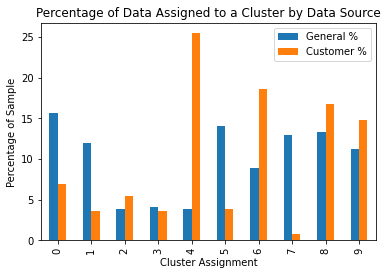

In [63]:
# plot a comparison of the percentages
cluster_percentage.sort_values('Cluster').plot(x='Cluster', y=['General %', 'Customer %'], kind='bar')

plt.title('Percentage of Data Assigned to a Cluster by Data Source')
plt.xlabel('Cluster Assignment')
plt.ylabel('Percentage of Sample');

Customers are highly overrepresented in clusters 4 and 6 - so, these will be a target audience for the company. Customers are highly underrepresented in clusters 0, 1, 5 and 7 - so, these customers are definetly outside of the target demographic. The rest of the clusters are close enough to where we can't tell either way from this analysis.

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


In [77]:
cluster_centroid_4 = st_scaler_a.inverse_transform(pca_122.inverse_transform(kmeans_10.cluster_centers_[4])) 

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.47170211e-01 -7.00561236e-01 -2.69716744e-01 -1.11864898e-01
  1.53752655e-01 -1.40582276e-01  2.75407184e-02 -6.54887478e-02
  2.64093975e-01  2.82780257e-01  4.78450560e-02  5.78772825e-02
 -4.19871438e-02 -3.85140370e-02 -1.20130129e-01 -1.68489464e-01
 -1.51992603e-01  7.69710724e-02  5.61888577e-02  3.62598969e-02
  2.65516831e-01  9.05524017e-02  6.65622249e-02  3.10624609e-02
  1.24561726e-01  2.65579807e-01 -2.04995177e-02 -3.34040392e-02
  3.16698097e-02  6.85655611e-02 -2.71784427e-02 -7.04563586e-03
  6.28965606e-02  6.64705875e-02  4.75190974e-02 -4.22624085e-02
 -2.16239189e-02 -2.55555096e-02 -3.16712674e-02  1.70900404e-02
  4.04037111e-02 -1.63796985e-02 -6.10063459e-03 -1.80089696e-03
  8.22534018e-03 -7.04300018e-02 -6.80582798e-03 -5.97433147e-02
 -7.65541502e-02 -8.34085675e-02 -2.68503240e-02  9.31093943e-03
 -9.97589249e-02 -9.00605175e-02 -4.90595350e-02 -7.37240731e-02
 -3.18588326e-02 -5.87339308e-02 -5.91829451e-02 -9.84258650e-02
 -8.57623876e-02  4.64653250e-02 -5.56931792e-02  1.02523978e-01
  1.86776324e-02 -2.20519508e-02 -1.02112861e-01 -2.15175760e-01
  1.13960560e-01 -1.69237861e-01  1.90320088e-02 -1.41411712e-01
 -1.00881323e-01  5.47080086e-01 -1.27125465e-01 -4.56971656e-01
 -3.48850625e-01  5.78978453e-01 -2.72537251e-01 -1.19024524e-01
  2.88669811e-01  3.23038352e-01  5.42646896e-02 -2.98375072e-01
  1.41752195e-02 -2.77562206e-04  1.27998234e-03 -1.01536066e-01
  2.53094541e-01 -2.02249357e-02  3.17356845e-02 -4.12759220e-02
 -1.27689143e-01 -1.16139249e-01  5.86286257e-02  2.56671771e-02
  1.01231277e-01  4.54237595e-03  1.31002692e-01  7.65633047e-02
 -9.07680788e-02  9.72749606e-01 -1.43827858e-01 -6.51657533e-01
 -5.26078979e-02  5.55955229e-01 -2.42267044e-02 -2.76462025e-01
 -1.87629498e-01  4.10237187e-01  8.95173689e-02 -1.07153124e-01
  1.10773984e-01 -1.90381707e-01  1.77244831e-01  1.43555539e-01
  1.19615260e-01 -1.77899918e-02 -4.31355664e-02 -2.45835614e-02
 -6.39375941e-02 -1.31841001e-01 -1.30437479e-01  5.67705572e-03
 -1.90381707e-01  1.19615260e-01 -5.16209685e-02 -1.99201001e-01
  2.36212927e-01 -2.75558229e-01  1.27543461e+00 -5.89496667e-02
 -1.43772022e-01 -1.22189875e-01 -3.66021980e-02 -1.78307421e-01
 -2.46193703e-01 -1.82380077e-02 -4.15960056e-01 -2.88352971e-01
 -2.01325384e-01 -2.79513311e-01 -4.02718856e-01  1.27543461e+00
 -1.07438564e-01  4.76547832e-01 -9.22468318e-01  7.68461115e-02
 -7.14243549e-02 -7.11435923e-02  1.06339831e-01  1.13146668e-01
  1.78186940e-01  3.04765318e-01 -2.51624212e-02 -1.51419517e-01
 -2.01949281e-01 -2.56131128e-01  2.57542947e-01  7.96640166e-02
 -1.40924146e-01  3.77360223e-02  1.69060415e-01 -5.20185853e-01
 -3.82743097e-01  4.35321894e-01 -6.66123134e-01 -6.65379234e-01
  4.89750222e-01  2.23211486e-01  2.00398251e-01 -1.20246382e-01
 -3.20826272e-01  1.94916631e-01  3.80992811e-01 -2.00390762e-02
  7.10209284e-01  2.49998134e-01 -1.39896280e-01 -1.66166127e-01
  9.89589737e-02 -1.72237740e-02 -1.13230201e-01  2.19443063e-01
 -3.61964277e-01  5.70985195e-03  6.44050109e-01 -4.73745582e-02
 -2.22361304e-01 -1.62365440e-01 -4.17983689e-02 -1.16964349e-01
  2.55608655e-01 -3.87622882e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
cluster_centroid_4

In [ ]:
customer_data = pd.concat([cust_scaled_df, cust_preds_df],axis=1)
azdias_data = pd.concat([azdias_scaled_df, azdias_preds_df],axis=1)

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.